# Assessment for Advanced Data Science

## Christian Cabrera, Carl Henrik Ek and Neil D. Lawrence

### 29th October 2021



Welcome to the course assessment for the Advanced Data Science unit. In this assessment you will build a prediction system for UK house prices. 

Your prediction system will be based on data from the UK Price Paid data available [here](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). By combining this data with the UK Office for National Statistics data on the latitude/longitude of postcodes (available [here](https://www.getthedata.com/open-postcode-geo)) you will have a record of house prices and their approximate latitude/longitude. Due to the size of these data you will use a relational database to handle them.  

To make predictions of the house price you will augment your data with information obtained from Open Street Map: an open license source of mapping information. You will use the techniques you have learnt in the course to indentify and incorporate useful features for house price prediction.



Alongside your implementation you will provide a short repository overview describing how you have implemented the different parts of the project and where you have placed those parts in your code repository. You will submit your code alongside a version of this notebook that will allow your examiner to understand and reconstruct the thinking behind your analysis. This notebook is structured to help you in creating that description and allow you to understand how we will allocate the marks. You should make use of the Fynesse framework (<https://github.com/lawrennd/fynesse_template>) for structuring your code. 

Remember the notebook you create should *tell a story*, any code that is not critical to that story can safely be placed into the associated analysis library and imported for use (structured as given in the Fynesse template)

The maximum total mark for this assessment is 20. That mark is split into Three Questions below, each worth 5 marks each. Then a final 5 marks will be given for the quality, structure and reusability of the code and analysis you produce giving 20 marks in total.


### Useful Links

You may find some of the following links useful when building your system.

University instuctions on Security and Privacy with AWS.

https://help.uis.cam.ac.uk/service/network-services/hosting-services/AWS/aws-security-privacy

Security Rules in AWS 

https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/USER_VPC.Scenarios.html#USER_VPC.Scenario4

### Installing Your Library

One artefact to be included in your submission is a python library structured according to the "Access, Assess, Address" standard for data science solutions. You will submit this library alongside your code. Use the cell below to perform the necessary installation instructions for your library.

You should base your module on the template repository given by the Fynesse template repository. That should make it `pip` installable as below. 



In [ ]:
# the cell below installs the library; I've hidden it by default because of the Github username

In [ ]:
#@title
%pip install git+https://github.com/antoniaboca/ads_course_assessment.git

In [1]:
%pip install -U PyYaml

     |████████████████████████████████| 596 kB 5.1 MB/s 
  Attempting uninstall: PyYaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Your own library should be installed in the line above, then you can import it as usual (where you can either replace `fynesse` with the name you've given your analysis module or you can leave the name as `fynesse` as you prefer).

In [2]:
import fynesse

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Question 1. Accessing a Database of House Prices, Latitudes and Longitudes

The UK price paid data for housing in dates back to 1995 and contains millions of transactions. The size of the data makes it unwieldy to manipulate directly in python frameworks such as `pandas`. As a result we will host the data in a *relational database*. 

Using the following ideas.

1. A cloud hosted database (such as MariaDB hosted on the AWS RDS service).
2. The SQL language wrapped in appropriately structured python code.
3. Joining of two databases.

You will construct a database containing tables that contain all house prices, latitudes and longitudes from the UK house price data base since 1995.

You will likely find the following resources helpful.

1. Lecture 1, 2 and 3.
2. Lab class 1 and 2.
3. The UK Price Paid data for houses: <https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads>
4. The UK ONS Data base of postcode latitude and longitudes:  <https://www.getthedata.com/open-postcode-geo>

Below we provide codeboxes and hints to help you develop your answer.

*The main knowledge you need to do a first pass through this question will have been taught by the end of Lab Session 2 (11th November 2021). You will likely want to review your answer as part of **refactoring** your code  and analysis pipeline shortly before hand in.*

*5 Marks*

### Task A

Set up the database. You'll need to set up a database on AWS. You were guided in how to do this in the lab sessions. You should be able to use the same database instance you created in the lab, or you can delete that and start with a fresh instance. You'll remember from the lab that the database requires credentials (username, password) to access. It's good practice to store those credentials *outside* the notebook so you don't accidentally share them by e.g. checking code into a repository. 
  
Call the database you use for this assessment `property_prices`.
  

In [5]:
# Write code for requesting and storing credentials (username, password) here. 
import yaml
from ipywidgets import interact_manual, Text, Password
from fynesse import access

@interact_manual(username=Text(description="Username:"), 
                 password=Password(description="Password:"))
def write_credentials(username, password):
    with open("credentials.yaml", "w") as file:
        credentials_dict = {'username': username, 
                            'password': password}
        yaml.dump(credentials_dict, file)

interactive(children=(Text(value='', description='Username:'), Password(description='Password:'), Button(descr…

In [6]:
# Write any other setup code you need for setting up database access here.
from fynesse import access

database_details = {"url": "test-mariadb.ccbxrkjdylas.eu-west-2.rds.amazonaws.com", 
                    "port": 3306}
                  
user, password = access.read_credentials()

In [ ]:
# creating the 'property_prices' database
conn = access.create_connection(user, password, database_details['url'], None)
access.create_database(conn)
conn.close()

Affected rows: 0


In [7]:
# use connection to 'property_prices'
conn = access.create_connection(user, password, database_details['url'], 'property_prices')

### Task B

Create a database table called `pp_data` containing all the UK Price Paid data from the [gov.uk site](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). You'll need to prepare a new table to receive the data and upload the UK Price Paid data to your database instance. The total data is over 3 gigabytes in size. We suggest that rather than downloading the full data in CSV format, you use the fact that they have split the data into years and into different parts per year. For example, the first part of the data for 2018 is stored at <http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018-part1.csv>. Each of these files is less than 100MB and can be downloaded very quickly to local disk, then uploaded using 


```
LOCAL DATA LOAD INFILE 'filename' INTO TABLE `table_name`
FIELDS TERMINATED BY ',' 
LINES STARTING BY '' TERMINATED BY '\n';
```
*Note* this command should be wrapped and placed in an appropriately structured python module. 

Each 'data part' should be downloadable from the `gov.uk` site and uploadable to your database instance in a couple of seconds. By looping across the years and different parts, you should be able to robustly upload this large data set to your database instance in a matter of minutes. 

You may find the following schema useful in creation of your database:

```
--
-- Table structure for table `pp_data`
--
DROP TABLE IF EXISTS `pp_data`;
CREATE TABLE IF NOT EXISTS `pp_data` (
  `transaction_unique_identifier` tinytext COLLATE utf8_bin NOT NULL,
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
  `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `primary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `secondary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `street` tinytext COLLATE utf8_bin NOT NULL,
  `locality` tinytext COLLATE utf8_bin NOT NULL,
  `town_city` tinytext COLLATE utf8_bin NOT NULL,
  `district` tinytext COLLATE utf8_bin NOT NULL,
  `county` tinytext COLLATE utf8_bin NOT NULL,
  `ppd_category_type` varchar(2) COLLATE utf8_bin NOT NULL,
  `record_status` varchar(2) COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;
```
This schema is written by Dale Potter and can be found on Github here: <https://github.com/dalepotter/uk_property_price_data/blob/master/create_db.sql>

You may also find it helpful to set up the following indexes in the database

```
--
-- Indexes for table `pp_data`
--
ALTER TABLE `pp_data`
ADD PRIMARY KEY (`db_id`);
MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;
CREATE INDEX `pp.postcode` USING HASH
  ON `pp_data`
    (postcode);
CREATE INDEX `pp.date` USING HASH
  ON `pp_data` 
    (date_of_transfer);
```


In the box below, briefly describe what the schema is doing and why we will find it useful to create the indexes we have for the table we've created.

> The schema is useful because it provides a structured way of looking at data. This tells both the programmer and the database what to expect when inputing values into the table. Having a schema might also allow for space optimisations, since the database knows the maximum width of a column.

> Indexes are a way of sorting records within a table so rows can be found quickly on some query. In our particular case:
1. The index for **postcode** will allow us to query records by the postcode column in an efficient manner. This will be useful later, when we will be joining pp_data with postcode_data to get the longitude and latitude of a house.
2. The index for **date_of_transfer** will be useful when we will be querying the database for training data in a particular time range.



In [ ]:
# Write the code you need for creating the database table and uploading the data here.
from fynesse import access

access.create_pp_data(conn)

# Loading all years from 1995 to 2021 into the `pp_data` table
gov_url = "http://prod2.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/"
access.load_gov_data(conn, gov_url)



> We can check that we've loaded the data properly:



In [8]:
from fynesse import access

access.table_head(conn, 'pp_data', limit=3)

Affected rows: 3


,transaction_unique_identifier,price,date_of_transfer,postcode,property_type,new_build_flag,tenure_type,primary_addressable_object_name,secondary_addressable_object_name,street,locality,town_city,district,county,ppd_category_type,record_status,db_id
0,{C8A3A576-4E89-0425-E053-6C04A8C0947B},140000,2021-03-18,BB1 8BT,T,N,F,26,,PARK AVENUE,,BLACKBURN,BLACKBURN WITH DARWEN,BLACKBURN WITH DARWEN,A,A,1
1,{C8A3A576-4E8A-0425-E053-6C04A8C0947B},80500,2021-06-18,FY7 7ND,T,N,F,3,,NORTHFLEET AVENUE,,FLEETWOOD,WYRE,LANCASHIRE,B,A,2
2,{C8A3A576-4E8B-0425-E053-6C04A8C0947B},220000,2021-06-18,PR26 7AW,D,N,F,91,,FERNLEIGH,,LEYLAND,SOUTH RIBBLE,LANCASHIRE,A,A,3


### Task C

Create a database table called `postcode_data` containing the ONS Postcode information. <GetTheData.com> has organised data derived from the UK Office for National Statistics into a convenient CSV file. You can find details [here](https://www.getthedata.com/open-postcode-geo).


The data you need can be found at this url: <https://www.getthedata.com/downloads/open_postcode_geo.csv.zip>. It will need to be unzipped before use.

You may find the following schema useful for the postcode data (developed by Christian and Neil)

```
USE `property_prices`;
--
-- Table structure for table `postcode_data`
--
DROP TABLE IF EXISTS `postcode_data`;
CREATE TABLE IF NOT EXISTS `postcode_data` (
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `status` enum('live','terminated') NOT NULL,
  `usertype` enum('small', 'large') NOT NULL,
  `easting` int unsigned,
  `northing` int unsigned,
  `positional_quality_indicator` int NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `lattitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `postcode_no_space` tinytext COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_seven` varchar(7) COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_eight` varchar(8) COLLATE utf8_bin NOT NULL,
  `postcode_area` varchar(2) COLLATE utf8_bin NOT NULL,
  `postcode_district` varchar(4) COLLATE utf8_bin NOT NULL,
  `postcode_sector` varchar(6) COLLATE utf8_bin NOT NULL,
  `outcode` varchar(4) COLLATE utf8_bin NOT NULL,
  `incode` varchar(3)  COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin;
```

And again you'll want to set up indices for your table.

```
ALTER TABLE `postcode_data`
ADD PRIMARY KEY (`db_id`);
MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;
CREATE INDEX `po.postcode` USING HASH
  ON `postcode_data`
    (postcode);
```

And you can load the CSV file into the table in one "INFILE".

```
LOAD DATA LOCAL INFILE 'open_postcode_geo.csv' INTO TABLE `postcode_data`
FIELDS TERMINATED BY ',' 
LINES STARTING BY '' TERMINATED BY '\n';
```

In [ ]:
# create the postcode_data table
from fynesse import access

postcode_url = 'https://www.getthedata.com/downloads/open_postcode_geo.csv.zip'
access.create_postcode_data(conn)
access.load_postcode_data(conn, postcode_url)

Affected rows: 0
Saved file to postcode.csv.zip
Extracted file into .
Affected rows: 2581933




> Again, we can check that we have loaded the data properly:



In [9]:
access.table_head(conn, 'postcode_data', limit=3)

Affected rows: 3


,postcode,status,usertype,easting,northing,positional_quality_indicator,country,latitude,longitude,postcode_no_space,postcode_fixed_width_seven,postcode_fixed_width_eight,postcode_area,postcode_district,postcode_sector,outcode,incode,db_id
0,AB1 0AB,terminated,small,385177,801314,1,Scotland,57.10255400,-2.24630800,AB10AB,AB1 0AB,AB1 0AB,AB,AB1,AB1 0,AB1,0AB,1
1,AB1 0AD,terminated,small,385053,801092,1,Scotland,57.10055600,-2.24834200,AB10AD,AB1 0AD,AB1 0AD,AB,AB1,AB1 0,AB1,0AD,2
2,AB1 0AE,terminated,small,384600,799300,8,Scotland,57.08444400,-2.25570800,AB10AE,AB1 0AE,AB1 0AE,AB,AB1,AB1 0,AB1,0AE,3


### Task D 

These data can now be joined to form a new table that contains house price paid and latitude longitude of the house. We could create a new table that contains all this information. However, the computation of that table will take some time because of the size of the two existing tables in the join. 

Instead, we're going to exploit the nature of the task. To build our prediction model, we're going to use the prices for a particular region in a given time period. This means we can select that region and time period and build the joined data only from the relevent rows from the two tables. This will save time on the join.

Whether this is a good idea or not in a live system will depend on how often these predictions are required. If it's very often, it would likely be better to store the entired database joined, because the one-off cost for that join is amortised across all the future predictions. If only a few predictions are required (like in our lab class) then doing that join on the fly might be better. In that case you can make use of an  *inner join* for this data set creation.

```
USE `property_prices`;
--
-- Table structure for table `prices_coordinates_data`
--
DROP TABLE IF EXISTS `prices_coordinates_data`;
CREATE TABLE IF NOT EXISTS `prices_coordinates_data` (
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
  `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `locality` tinytext COLLATE utf8_bin NOT NULL,
  `town_city` tinytext COLLATE utf8_bin NOT NULL,
  `district` tinytext COLLATE utf8_bin NOT NULL,
  `county` tinytext COLLATE utf8_bin NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `lattitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;


```



In [ ]:
# Creating 'prices_coordinates_data'

from fynesse import access
access.create_prices_coordinates_data(conn)

Affected rows: 0


()



> Now, it is worth mentioning that `prices_coordinates_data` will **cache** the results of whatever joins we will be doing on the fly in Question 3. This, roughly, how we select the data to update this table:

```
  query = f"""
    SELECT p.price, p.date_of_transfer, p.postcode, p.property_type, 
    p.new_build_flag, p.tenure_type, p.locality, p.town_city, p.district, p.county, c.country, c.latitude, c.longitude FROM
      (SELECT postcode, country, latitude, longitude FROM postcode_data
      WHERE latitude BETWEEN '{south}' AND '{north}' AND longitude BETWEEN '{west}' AND '{east}') c
    INNER JOIN  
      (SELECT * FROM pp_data
        WHERE date_of_transfer BETWEEN '{start_time}' AND '{end_time}' AND property_type = '{property_type}'
        AND postcode NOT IN (SELECT postcode FROM prices_coordinates_data)) p
    ON
      p.postcode = c.postcode 
  """
```
> So the way we are using `prices_coordinates_data` is the following:     
1. Search for houses that are not in `prices_coordinates_data`, i.e. these are houses for which we don't have coordinates yet. 
2. Join these houses with their corresponding coordinates, using `postcode_data`.
3. Update `prices_coordinates_data` with these newly-found houses.
4. Query `prices_coordinates_data` for the houses we need for our model.



> Now that we have created all three tables, we can check their sizes:



In [10]:
from fynesse.access_scripts import sql

sql.database_size(conn)

Affected rows: 3


,TABLE_SCHEMA,TABLE_NAME,Approximate size (MB)
0,property_prices,pp_data,5820.98
1,property_prices,postcode_data,343.48
2,property_prices,prices_coordinates_data,0.61


## Question 2. Accessing OpenStreetMap and Assessing the Available Features

In question 3 you will be given the task of constructing a prediction system for property price levels at a given location. We expect that knowledge of the local region around the property should be helpful in making those price predictions. To evaluate this we will now look at [OpenStreetMap](https://www.openstreetmap.org) as a data source.

The tasks below will guide you in accessing and assessing the OpenStreetMap data. The code you write will eventually be assimilated in your python module, but documentation of what you've included and why should remain in the notebook below. 

Accessing OpenStreetMap through its API can be done using the python library `osmx`. Using what you have learned about the `osmx` interface in the lectures, write general code for downloading points of interest and other relevant information that you believe may be useful for predicting house prices. Remembering the perspectives we've taken on *data science as debugging*, the remarks we've made when discussing *the data crisis* of the importance of reusability in data analysis, and the techniques we've explored in the labsessions for visualising features and exploring their correlation use the notebook to document your assessment of the OpenStreetMap data as a potential source of data.

The knowledge you need to do a first pass through this question will have been taught by end of lab session three (16th November 2021). You will likely want to review your answer as part of *refactoring* your code and analysis pipeline shortly before hand in.

You should write reusable code that allows you to explore the characteristics of different points of interest. Looking ahead to question 3 you'll want to incorporate these points of interest in your prediction code.

*5 marks*


### **First part**: global trends

> Before starting with OpenStreetMap, I've decided to see how the data 'looks like'. Of course we all expect that the location of a house influences its price, but how important is this factor? 
For example, we all know that London is expensive. But how expensive is it?

> My `assess` module runs code that asserts everything I've loaded into my database is valid. It should raise `AssertionError` whenever a column that is necessary for my analysis isn't there - like price, for example.

In [11]:
!mkdir data

Affected rows: 4623
Assessing dataframe...
Assessment is finished.


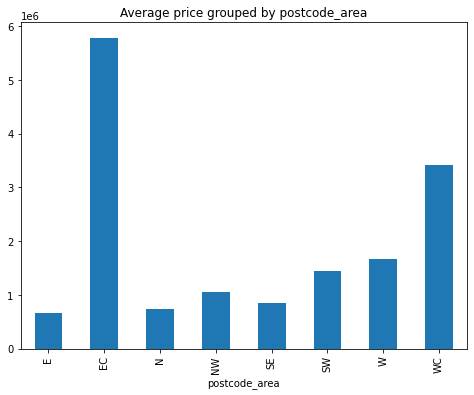

In [12]:
# Use this cell and cells below for summarising your analysis and documenting your decision making.

from fynesse import assess, access

# Let's see how expensive London was in January, 2019
london = access.region_data(conn, '2019-01-01', '2019-01-31', 'town_city', 'London')
london = assess.assess_houses(london)
assess.show_average_bar(london, group_by='postcode_area')

In [13]:
# But how does that look on a map?
# Let's load the boundaries of London neighbourhoods and compute the average price in each

url = "https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip"
access.load_london_wards(url)
region_map = './data/statistical-gis-boundaries-london/ESRI/London_Ward_CityMerged.shp'


Saved file to ./data/london-wards.zip
Extracted file into ./data/


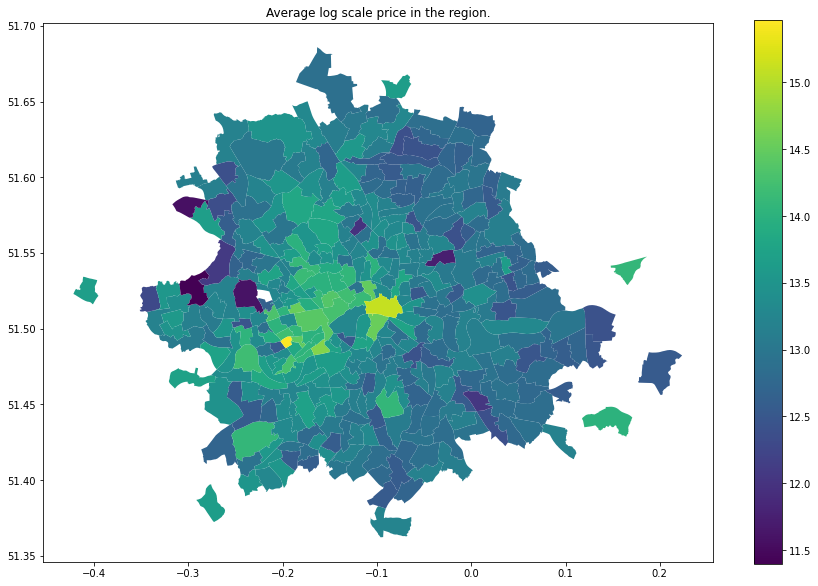

In [16]:
london, map_df = assess.query_map(london, region_map)
assess.show_average_map(london, map_df, figsize=(15, 10), log_scale=True)



> We can clearly see a tendency towards more expensive houses in central London. Now let's look at different types of properties. I hypothesize that in general, flats are less expensive than detached houses, for example.



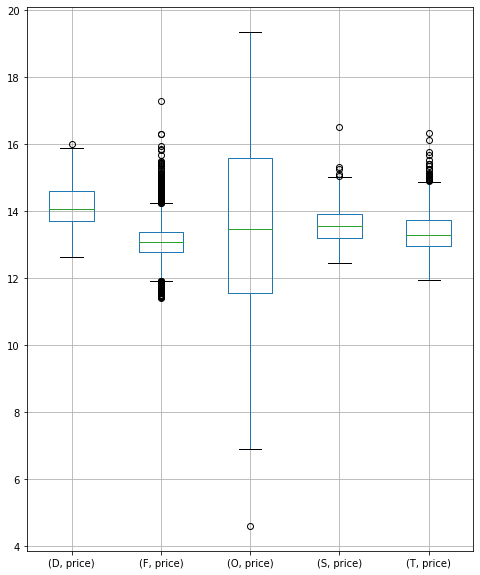

In [17]:
# Check tendencies for property_types
assess.show_boxplot(london, grouped='property_type', log_scale=True)

> We can see that `property_type = OTHER` means a more spread out range of values (which makes sense, since it `OTHER` could mean both a mansion or a cottage. Also, the average price of a flat is less than the average price of a detached house, but there are some outlier flats that are more expensive (probably some penthouses in South Kensington).

> Therefore, my first decision for the model will be to split it up by **property type**. When predicting the price of a flat, I will only be analyzing other flats, for example.

> Analyzing property types from a different perspective, we might be able to hypothesize a distribution they might be coming from:

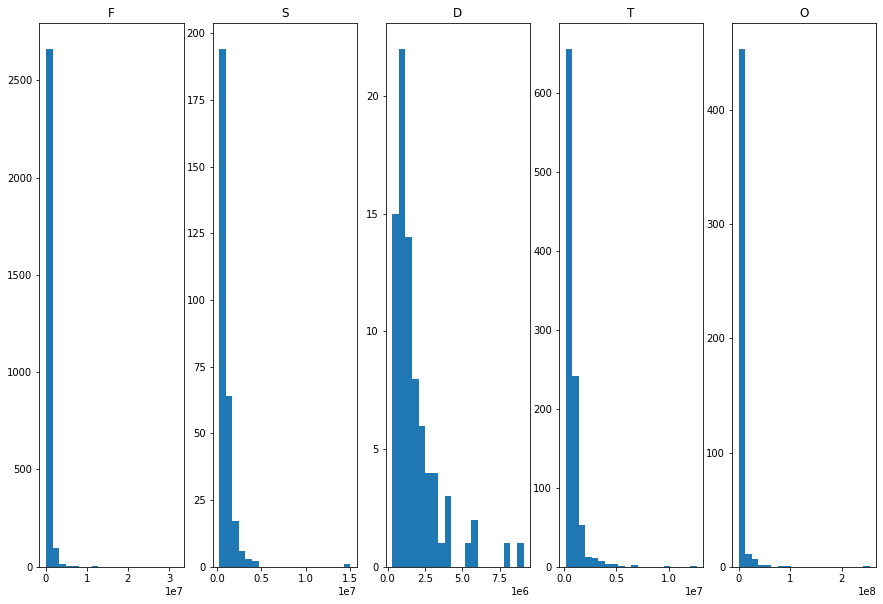

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,5)
fig.set_size_inches(15, 10)
prop_types = ['F', 'S', 'D', 'T', 'O']
count = 0
for prop in prop_types:
  houses = london[london['property_type'] == prop]
  axs[count].hist(houses['price'], bins=20)
  axs[count].set_title(prop)
  count += 1

> All of them are skewed to the left, with a long tail to the right. I'd like to see what happens if I apply a transformation to them. Will they become Normal distributions? Fortunately, `scipy` has the `shapiro-wilk` test that I can use to check.

Distribution for F does not look Gaussian
Distribution for S does not look Gaussian
Distribution for D looks Gaussian
Distribution for T does not look Gaussian
Distribution for O does not look Gaussian


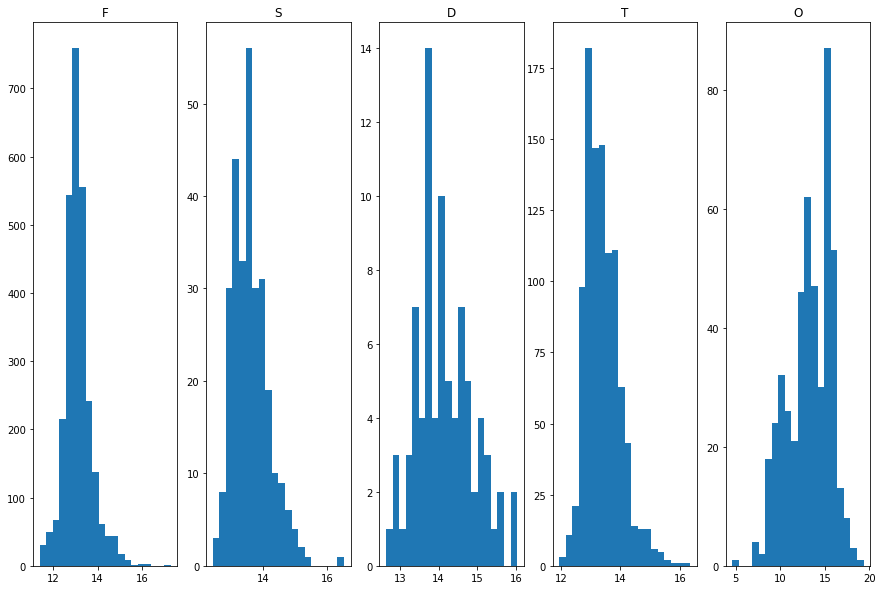

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import shapiro

# significance testing to see whether the distribution of prices is, in fact, normal
# after applying a log-transformation.

fig, axs = plt.subplots(1,5)
fig.set_size_inches(15, 10)
prop_types = ['F', 'S', 'D', 'T', 'O']
count = 0
for prop in prop_types:
  houses = london[london['property_type'] == prop]
  axs[count].hist(np.log(houses['price']), bins=20)
  axs[count].set_title(prop)
  count += 1

  _, p = shapiro(np.log(houses['price']))
  if p > 0.05:
    print(f'Distribution for {prop} looks Gaussian')
  else:
    print(f'Distribution for {prop} does not look Gaussian')
  

> We can see that general price tendencies do not follow a Normal distribution. However, from the look of the non-transformed histograms we could try to fit each property type under a Gamma distribution.

### **Second part**: local trends

> The next thing I am curious about is how the prices are distributed within a certain bouding box. Let's say I choose a house and take all houses nearby. What would the distribution of prices look like?

In [20]:
from fynesse import assess

# Let's take a house from oxford
latitude = 51.76129500
longitude = -1.21155800
h_price = 400000

box = assess.get_box(latitude, longitude, 0.09, 0.08)
oxford = access.box_data(conn, box, '2018-06-01', '2020-06-01', 'F')
oxford = assess.assess_houses(oxford)

Affected rows: 0
Affected rows: 0
Loaded rows from temp_join.csv to prices_coordinates_data
Affected rows: 702
Assessing dataframe...
Assessment is finished.


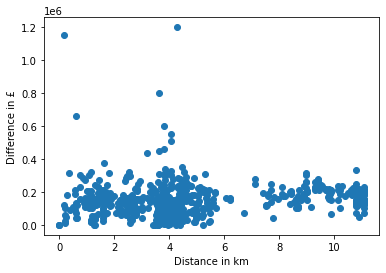

In [21]:
from geopy import distance
import matplotlib.pyplot as plt
import numpy as np

dist = [distance.distance((lat, long), (latitude, longitude)).km for lat, long in zip(oxford['latitude'], oxford['longitude'])]
plt.xlabel("Distance in km")
plt.ylabel("Difference in £")
plt.scatter(dist, np.abs(oxford['price'] - h_price))


> From this, I can draw two observations:    
1. There is **no** point in having a bounding box **bigger than 2km**
2. A house's price tends to be similar to the price of neighbouring houses (that have the same type). 

Then, let's take a closer look at a smaller bouding box.

In [22]:
# take a house in Manchester
longitude = -2.24465900
latitude = 53.43426900
h_price = 87900
prop_type = 'T'

box = assess.get_box(latitude, longitude, 0.01, 0.01)
manchester = access.box_data(conn, box, '2018-06-01', '2019-06-01', 'T')
manchester = assess.assess_houses(manchester)

Affected rows: 0
Affected rows: 0
Loaded rows from temp_join.csv to prices_coordinates_data
Affected rows: 76
Assessing dataframe...
Assessment is finished.


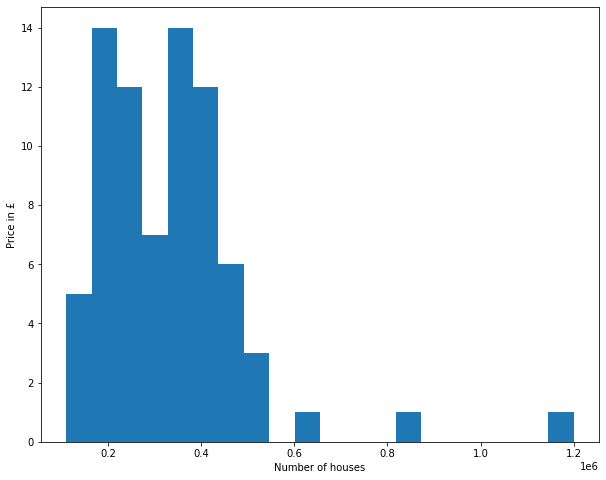

In [23]:
plt.figure(figsize=(10,8))
plt.ylabel('Price in £')
plt.xlabel('Number of houses')
plt.hist(manchester['price'], bins=20)
plt.show()

> This could be roughly modelled using a **Poisson distribution**. Then, the assumption of my model will be that the prices of houses around my coordinates follow this distribution.

### Third part: neighbourhood features

The observation that I can draw from the first and second parts is that houses in the same neighbourhood have similar prices. There are, however, variations in these prices, and I want to see how much of this variation is accounted for by amenities, such as schools, parking spaces, healthcare facilies and so on. Let's extract these using OpenStreetMap.

> Since I have chosen a Poisson distribution for my model, if OpenStreetMap features are influencing my model then I am expecting to see a linear relation between the number the number of POIs and the log of the price.

In [24]:
# Let's look at Oxford again

latitude = 51.76129500
longitude = -1.21155800
h_price = 400000

# I have chosen these tags as relevant
tags = {'amenity': True,
 'historic': True,
 'leisure': True,
 'shop': True,
 'tourism': True}

box = assess.get_box(latitude, longitude, 0.01, 0.01)
oxford = access.region_data(conn, '2015-01-01', '2015-06-01', 'town_city', 'Oxford')
oxford = assess.assess_houses(oxford)

Affected rows: 901
Assessing dataframe...
Assessment is finished.


In [25]:
# take a sample
sample = oxford.sample(30)

# Retrieve OpenStreetMap data for a sample
pois = access.pois_data(sample, tags)
pois = assess.assess_pois(pois, tags)

Loading all points from OpenStreetMap...


/usr/local/lib/python3.7/dist-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/usr/local/lib/python3.7/dist-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/usr/local/lib/python3.7/dist-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/usr/

Loaded all points.
Assess pois and compute total pois...
Stats computed.


In [26]:
import pandas as pd
merged = pd.concat([sample.reset_index(), pois], axis=1)

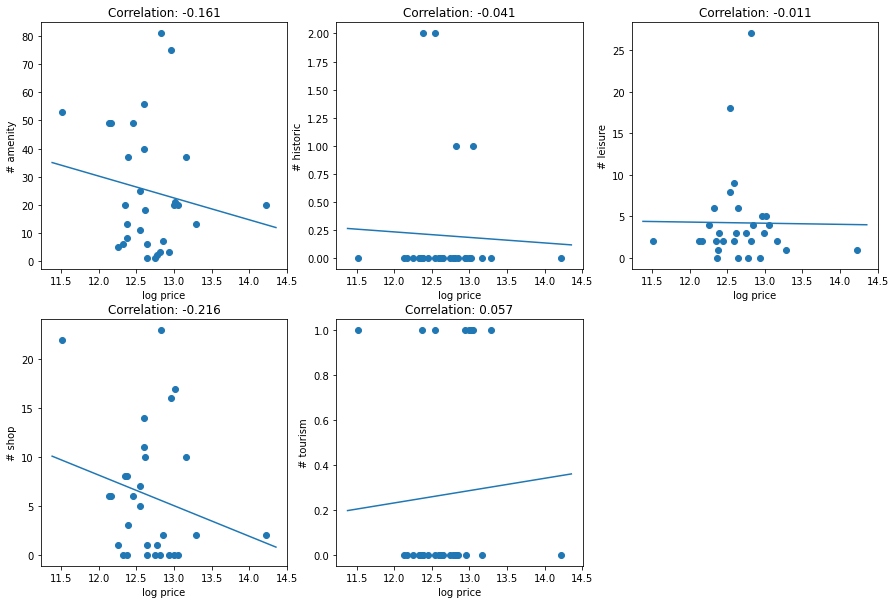

In [27]:
import matplotlib.pyplot as plt
from fynesse import assess

fig = plt.figure(figsize=(15,10))

count = 1
for tag in tags.keys():
  ax = fig.add_subplot(2, 3, count)
  assess.draw_correlation(np.log(merged['price']), merged[tag], ax, 'log price', f'# {tag}')
  count += 1

> We could be looking at specific neighbourhood features, such as parking spaces and schools:   

Loading all points from OpenStreetMap...
Loaded all points.


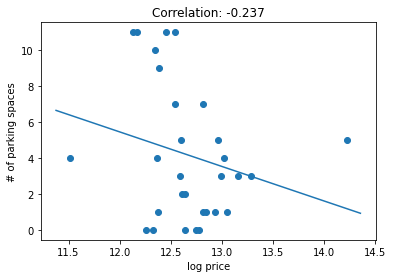

In [28]:
tags = {'amenity': 'parking'}
pois = access.pois_data(sample, tags)
merged = pd.concat([sample.reset_index(), pois], axis=1)
fig, ax = plt.subplots()
assess.draw_correlation(np.log(merged['price']), merged['amenity'], ax, 'log price', '# of parking spaces')

> Having done this analysis on other tags, such as `school`, `hospital`, `supermarket`, `kindergaden`, it seems that there doesn't exist a particular type of POI that has more influence than others. The absence of one type of amenity is easily offset by the presence of another type of amenity, so I have decided to look at the **total number** of POIs per tag.

Correlation for F: {'amenity': -0.3929020925235611}
Correlation for S: {'amenity': 0.5957223744324085}
Correlation for D: {'amenity': 0.9766039140387318}
Correlation for T: {'amenity': -0.676411806679681}
Correlation for O: {'amenity': nan}


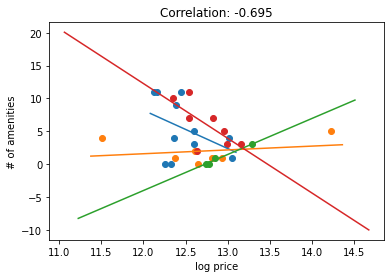

In [30]:
# Simpson’s Paradox

fig, ax = plt.subplots()
prop_type = ['F', 'S', 'D', 'T', 'O']
tags = {'amenity': True}
for prop in prop_type:
  df = merged[merged['property_type'] == prop]
  print(f"Correlation for {prop}: {assess.get_price_correlation(df, df, tags)}")
  if len(df) > 0:
    assess.draw_correlation(np.log(df['price']), df['amenity'], ax, 'log price', '# of amenities')

It is interesting to notice that the small correlation we have found earlier for the number of amenities, for example, is reversed for some groups when we split the sample into property types.


## Question 3. Addressing a Property Price Prediction Question

For your final tick, we will be asking you to make house price predictions for a given location, date and property type in the UK. You will provide a function that takes input a latitude and longitude as well as the `property_type` (either type" of property (either `F` - flat, `S` - semidetached, `D` - detached, `T` - terraced or `O` other). Create this function in the `address.py` file, for example in the form,

```
def predict_price(latitude, longitude, date, property_type):
    """Price prediction for UK housing."""
    pass
```

We suggest that you use the following approach when building your prediction. 

1. Select a bounding box around the housing location in latitude and longitude.
2. Select a data range around the prediction date. 
3. Use the data ecosystem you have build above to build a training set from the relevant time period and location in the UK. Include appropriate features from OSM to improve the prediction.
4. Train a linear model on the data set you have created.
5. Validate the quality of the model.
6. Provide a prediction of the price from the model, warning appropriately if your validation indicates the quality of the model is poor.

The knowledge you need to do a first pass through this question will have been taught by end of lab session four (25th November 2021). You will likely want to review your answer as part of *refactoring* your code shortly before hand in.



> To recap all the model decisions I have taken so far:   
1. Split data by `property_type`
2. Use a bounding box for latitude and longitude of **2 km**
3. Model prices in the bouding box using a **Poisson distribution**.
4. Add the total number of POIs for tags: `amenities`, `leisure`, `tourism`, `historic`, `shop`.

Getting house data...
Affected rows: 0
Affected rows: 0
Loaded rows from temp_join.csv to prices_coordinates_data
Affected rows: 33
Assessing dataframe...
Assessment is finished.

Getting OpenStreetMap features...
Loading all points from OpenStreetMap...
Loaded all points.
Assess pois and compute total pois...
Stats computed.

Building a model for the region around the house...
Spliting data into training and validation with test size: 0.2...
Picking features: ['latitude', 'longitude', 'amenity', 'historic', 'leisure', 'shop', 'tourism']...

Validate the model...


/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/generalized_linear_model.py:1133: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start_params = np.zeros(self.exog.shape[1], np.float)


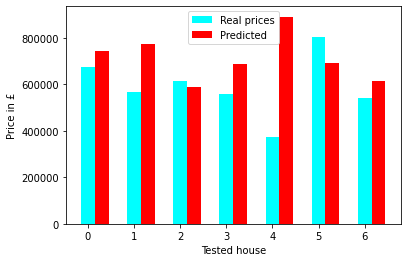

Predicting price for house...
Loading all points from OpenStreetMap...
Loaded all points.
Assess pois and compute total pois...
Stats computed.
Picking features: ['latitude', 'longitude', 'amenity', 'historic', 'leisure', 'shop', 'tourism']...


In [31]:
from fynesse import address 

predict, model = address.predict_price(conn, 51.381, -0.254, '2015-12-31', 'D')

In [33]:
print(f"Predicted value for house: {predict['mean'][0]}")

Predicted value for house: 792210.954862372
